In [1]:
!pip install torch torchvision torchaudio

In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [3]:
import torch.nn as nn 
import torch.nn.functional as F 

In [4]:
import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

In [5]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

In [6]:
train_data = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_data = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_data, batch_size=256, shuffle=True)
test_loader = DataLoader(test_data, batch_size=256, shuffle=False)

In [7]:
image, label = train_data[0]

In [8]:
print(image.size())

torch.Size([1, 28, 28])


In [9]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)  #28x28x32
        self.pool = nn.MaxPool2d(2, 2)  #14x14x32
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)  #14x14x64 converts to 7x7x64- don't have to define the pool layer again
        self.fc1 = nn.Linear(7*7*64, 128)  
        self.fc2 = nn.Linear(128, 10)  
    
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x,1)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)  
        return x

In [10]:
model = ConvNet()
loss_f = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

In [11]:
def init_weights(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
        if m.bias is not None:
            nn.init.zeros_(m.bias)

def train(model, train_loader, criterion, optimizer, epochs=5):
    model.apply(init_weights)
    model.train()  

    losses = [] 
    
    for epoch in range(epochs):
        running_loss = 0.0
        for images, labels in train_loader:
            optimizer.zero_grad()  
            outputs = model(images)  
            loss = criterion(outputs, labels)  
            loss.backward()  
            optimizer.step()  
            
            running_loss += loss.item()
            losses.append(loss.item())
        
        print(f'Epoch {epoch+1}, Loss: {running_loss/len(train_loader)}')
        
    plt.plot(losses, label="Loss")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.title("Loss vs Iterations")
    plt.legend()
    plt.show()

Epoch 1, Loss: 0.5805154269838587
Epoch 2, Loss: 0.08321905610092142
Epoch 3, Loss: 0.052958906731231416
Epoch 4, Loss: 0.03984786886325542
Epoch 5, Loss: 0.0328036593590328


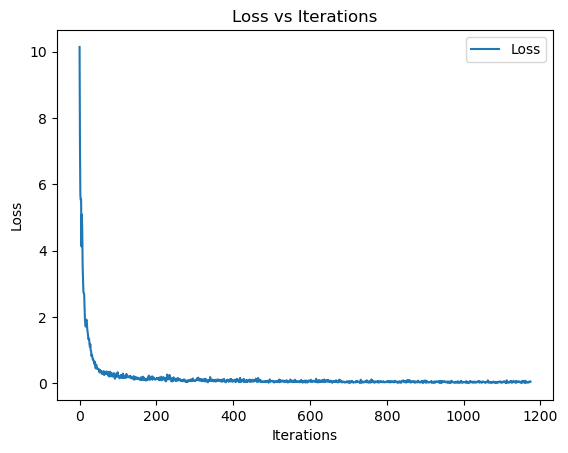

Model saved successfully!


In [12]:
train(model, train_loader, loss_f, optimizer, epochs=5)
torch.save(model.state_dict(), 'model.pth')
print("Model saved successfully!")

In [13]:
model = ConvNet()
model.load_state_dict(torch.load('model.pth'))  # Load weights from saved model file
model.eval() 

ConvNet(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=3136, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)

In [14]:
def make_inference(model, test_loader):
    correct = 0
    total = 0
    with torch.no_grad():  
        for images, labels in test_loader:
            outputs = model(images)  
            _, predicted = torch.max(outputs, 1)  
            total += labels.size(0) 
            correct += (predicted == labels).sum().item()
    
    accuracy = 100*correct/total
    print(f'Accuracy on test set: {accuracy}%')

make_inference(model, test_loader)

Accuracy on test set: 98.81%


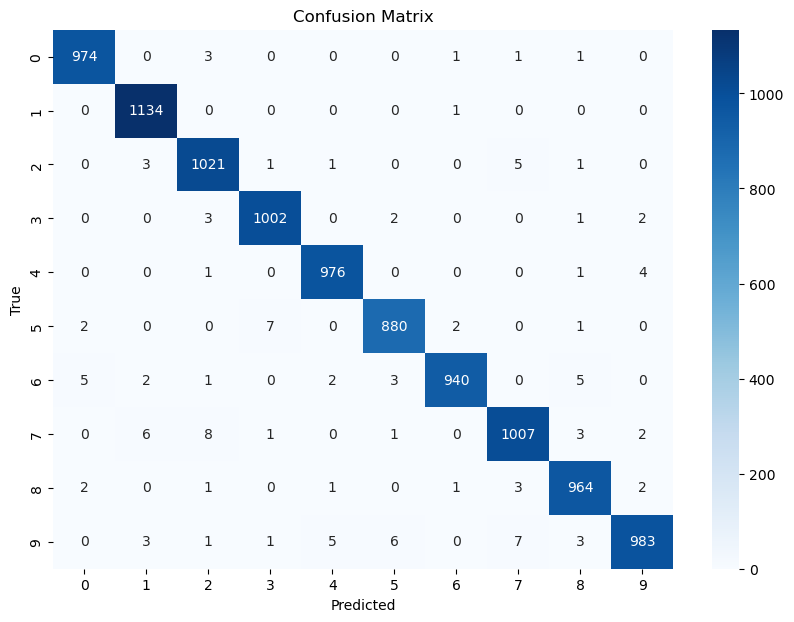

F1 Scores for each class: [0.99235863 0.9934297  0.9859971  0.99109792 0.99237417 0.98654709
 0.98791382 0.98196002 0.98669396 0.98201798]


In [15]:
from sklearn.metrics import confusion_matrix, f1_score

def make_inferences(model, test_loader):
    all_labels = []
    all_predictions = []
    
    with torch.no_grad():  
        for images, labels in test_loader:
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)   
            all_labels.extend(labels.numpy())
            all_predictions.extend(predicted.numpy())

    cm = confusion_matrix(all_labels, all_predictions)
    
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[str(i) for i in range(10)], yticklabels=[str(i) for i in range(10)])
    plt.title("Confusion Matrix")
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()
    
    f1 = f1_score(all_labels, all_predictions, average=None)
    print(f'F1 Scores for each class: {f1}')

make_inferences(model, test_loader)
